# <a id='toc1_'></a>[__Тестирование гипотез__](#toc0_)

**Содержание**<a id='toc0_'></a>    
- [__Тестирование гипотез__](#toc1_)    
  - [__Импорты и настройки__](#toc1_1_)    
  - [__Идея статистического теста__](#toc1_2_)    
  - [__I. Тесты для нормально распределенных случайных величин__](#toc1_3_)    
    - [__I.1. Дисперсия известна: z-тест (z-критерий Фишера)__](#toc1_3_1_)    
      - [__I.1.1. Сравнение среднего с константой: одновыборочный z-тест__](#toc1_3_1_1_)    
      - [__Ошибка 1-го рода, ошибка 2-го рода. Мощность статистического критерия. p-value__](#toc1_3_1_2_)    
      - [__I.1.2. Сравнение средних двух выборок: двухвыборочный z-тест__](#toc1_3_1_3_)    
    - [__I.2. Дисперсия неизвестна: t-тест (t-критерий Стьюдента)__](#toc1_3_2_)    
      - [__I.2.1. Сравнение среднего с константой: одновыборочный t-тест__](#toc1_3_2_1_)    
      - [__I.2.2. Сравнение средних двух выборок: двухвыборочный t-тест, _равные_ дисперсии__](#toc1_3_2_2_)    
      - [__I.2.3. Сравнение средних двух выборок: двухвыборочный t-тест, _различные_ дисперсии__](#toc1_3_2_3_)    
      - [__F-тест Фишера на равенство дисперсий__](#toc1_3_2_4_)    
      - [__Проверка на нормальность: тест Шапиро–Уилка__](#toc1_3_2_5_)    
  - [__II. Тесты для случайных величин, распределенных не нормально__](#toc1_4_)    
    - [__II.1. Сравнение среднего выборки с константой__](#toc1_4_1_)    
    - [__II.2. Сравнение средних двух выборок: U-тест Манна-Уитни__](#toc1_4_2_)    
  - [__III. Бинарные величины__](#toc1_5_)    
    - [__III.1. Сравнение среднего выборки с константой__](#toc1_5_1_)    
      - [__III.1.1. Приближенное решение__](#toc1_5_1_1_)    
      - [__III.1.2. Точное решение__](#toc1_5_1_2_)    
    - [__III.2. Сравнение средних двух выборок__](#toc1_5_2_)    
    - [__Tests for goodness of fit__](#toc1_5_3_)    
      - [__Дискретный случай: критерий согласия хи-квадрат (критерий согласия Пирсона)__](#toc1_5_3_1_)    
      - [__Непрерывный случай: критерий Колмогорова-Смирнова__](#toc1_5_3_2_)    
      - [__Критерий Смирнова__](#toc1_5_3_3_)    
      - [__Непрерывные в дискретные: группировка наблюдений__](#toc1_5_3_4_)    
    - [__Проверка зависимости: хи-квадрат, ANOVA, корреляция__](#toc1_5_4_)    
      - [__Дискретная/дискретная: критерий хи-квадрат__](#toc1_5_4_1_)    
      - [__Дискретная/непрерывная: дисперсионный анализ (ANOVA)__](#toc1_5_4_2_)    
      - [__Непрерывная/непрерывная: корреляция__](#toc1_5_4_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
## <a id='toc1_1_'></a>[__Импорты и настройки__](#toc0_)

In [1]:
# стандартная библиотека
from collections import namedtuple
from itertools import product

In [2]:
# сторонние библиотеки
from statistics import correlation
from scipy.stats import (
    chi2, chi2_contingency, chisquare, binom, 
    f as fdist, f_oneway, kstest, mannwhitneyu, 
    norm, pearsonr, uniform, zscore
)
from scipy.stats.contingency import margins
from statsmodels.distributions.empirical_distribution import ECDF
from statsmodels.stats.weightstats import ztest
import matplotlib, matplotlib.pyplot as plt
import black
import numpy as np
import seaborn as sns
import sympy as sym

In [3]:
# глобальные настройки графических библиотек
params = {'axes.spines.right': False, 'axes.spines.top': False}
sns.set_theme(palette='tab10', style='ticks', rc=params)
matplotlib.rcParams['figure.dpi'] = 400

In [4]:
def print_black(collection):
    """
    Вывод коллекции в наглядном структурированном виде.
    """
    print(black.format_str(repr(collection), mode=black.Mode()))

***
## <a id='toc1_2_'></a>[__Идея статистического теста__](#toc0_)

1. Сформировать из случайных величин $x_1,x_2,\ldots,x_n$​ одну случайную величину, которая будет обобщать интересующую информацию.

2. Понять, какое распределение получилось у этой случайной величины в предположении, что $H_0$​ верна. Желательно, чтобы это распределение было простым и понятным — например $N(0,1)$.

3. Принять решение об истинности или ложности $H_0$​ на основании реализации этой случайной величины, т.е. на основании одного числа, а не десяти.

***
## <a id='toc1_3_'></a>[__I. Тесты для нормально распределенных случайных величин__](#toc0_)

***
### <a id='toc1_3_1_'></a>[__I.1. Дисперсия известна: z-тест (z-критерий Фишера)__](#toc0_)

* Точечная оценка среднего:
$$\overline{x} = \frac{x_1+\ldots+x_n}{n}$$

* Доверительный интервал для среднего:
$$\biggl[\overline{x} - \overbrace{q_{\frac{1+\alpha}{2}}}^{\tiny \text{квантиль} \, N(0,1)} \cdot \frac{\sigma}{\sqrt{n}}, \; \overline{x} - q_{\frac{1-\alpha}{2}}\frac{\sigma}{\sqrt{n}}\biggr]$$

См. _Интервальная оценка среднего при известной дисперсии_ в [__stats_various.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_various.ipynb)

В такой записи $\alpha$ — уровень доверия, например, $0.95$. Эквивалентно можно записать в более интуитивной форме через комплиментарное слагаемое $\varepsilon$ (например, $0.05$):

$$\biggl[\overline{x} - q_{1 - \varepsilon / 2}\frac{\sigma}{\sqrt{n}}, \; \overline{x} + q_{1 - \varepsilon / 2}\frac{\sigma}{\sqrt{n}}\biggr]$$

— доверительный интервал уровня доверия $(1 - \varepsilon)$, расположенный по обе стороны от среднего.

***
#### <a id='toc1_3_1_1_'></a>[__I.1.1. Сравнение среднего с константой: одновыборочный z-тест__](#toc0_)

Статистика:
$$\frac{\overline{x} - \mu_0}{\sigma/\sqrt{n}} \sim N(0,1)$$

Используемый ниже пример: пищевая добавка для мышей, $\mu$ — средняя продолжительность жизни мыши в месяцах, $H_0$: $N(20,25)$, $H_1$: $N(24,25)$.

Посмотрим на распределение случайной величины $\frac{1}{10}\left(x_1+\ldots+x_{10}\right)$​ в предположении, что верна гипотеза $H_0$ и что все с.в. $x_i$ iid и каждая имеет распределение $N(20,25)$:

$$\frac{x_1+\ldots+x_{10}}{10} \sim N \left( \frac{200}{10}, \frac{250}{10^2} \right) = N(20,2.5)$$

$$\left( \frac{x_1+\ldots+x_{10}}{10} - 20 \right) \sim N(0,2.5), \quad \sqrt{2.5} = \sqrt{\frac{25}{10}} = \frac{5}{\sqrt{10}}$$

$$T(x_1,\ldots,x_{10}) = \left( \frac{\frac{x_1+\ldots+x_{10}}{10} - 20}{5 / \sqrt{10}} \right) \sim N(0,1)$$

[__scipy.stats.norm__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.norm.html#scipy-stats-norm) | [__statsmodels.stats.weightstats.ztest__](https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.ztest.html#generated-statsmodels-stats-weightstats-ztest--page-root)

In [5]:
fields = ['statistic', 'pvalue', 'decision']
ZtestHandmadeResult = namedtuple('ZtestHandmadeResult', fields)

In [6]:
def ztest_handmade(data, *, mu, s2=None, alpha=0.05, tail='right'):
    """
    A toy 1-sample z-test. Right tail only. Assignable variance. 
    """
    if tail != 'right':
        raise ValueError('Right-sided test only.')
    variance = s2 or np.var(data, ddof=1)
    statistic = (np.mean(data) - mu) / np.sqrt(variance / len(data))
    pvalue = norm.sf(statistic)  # 1 - norm.cdf(statistic)
    # decision = 'H1' if statistic > norm.ppf(1 - alpha) else 'H0'
    decision = 'H1' if pvalue < alpha else 'H0'    
    return ZtestHandmadeResult(statistic, pvalue, decision)

In [7]:
data = [9, 23, 16, 17, 21, 25, 19, 24, 23, 30]

In [8]:
# дисперсия назначена
ztest_handmade(data, mu=20, s2=25)

ZtestHandmadeResult(statistic=0.4427188724235726, pvalue=0.32898454503191044, decision='H0')

In [9]:
# использована несмещенная оценка дисперсии
ztest_handmade(data, mu=20)

ZtestHandmadeResult(statistic=0.38207087422295516, pvalue=0.35120439746721477, decision='H0')

In [10]:
ztest(data, value=20, alternative='larger')

(0.38207087422295516, 0.35120439746721477)

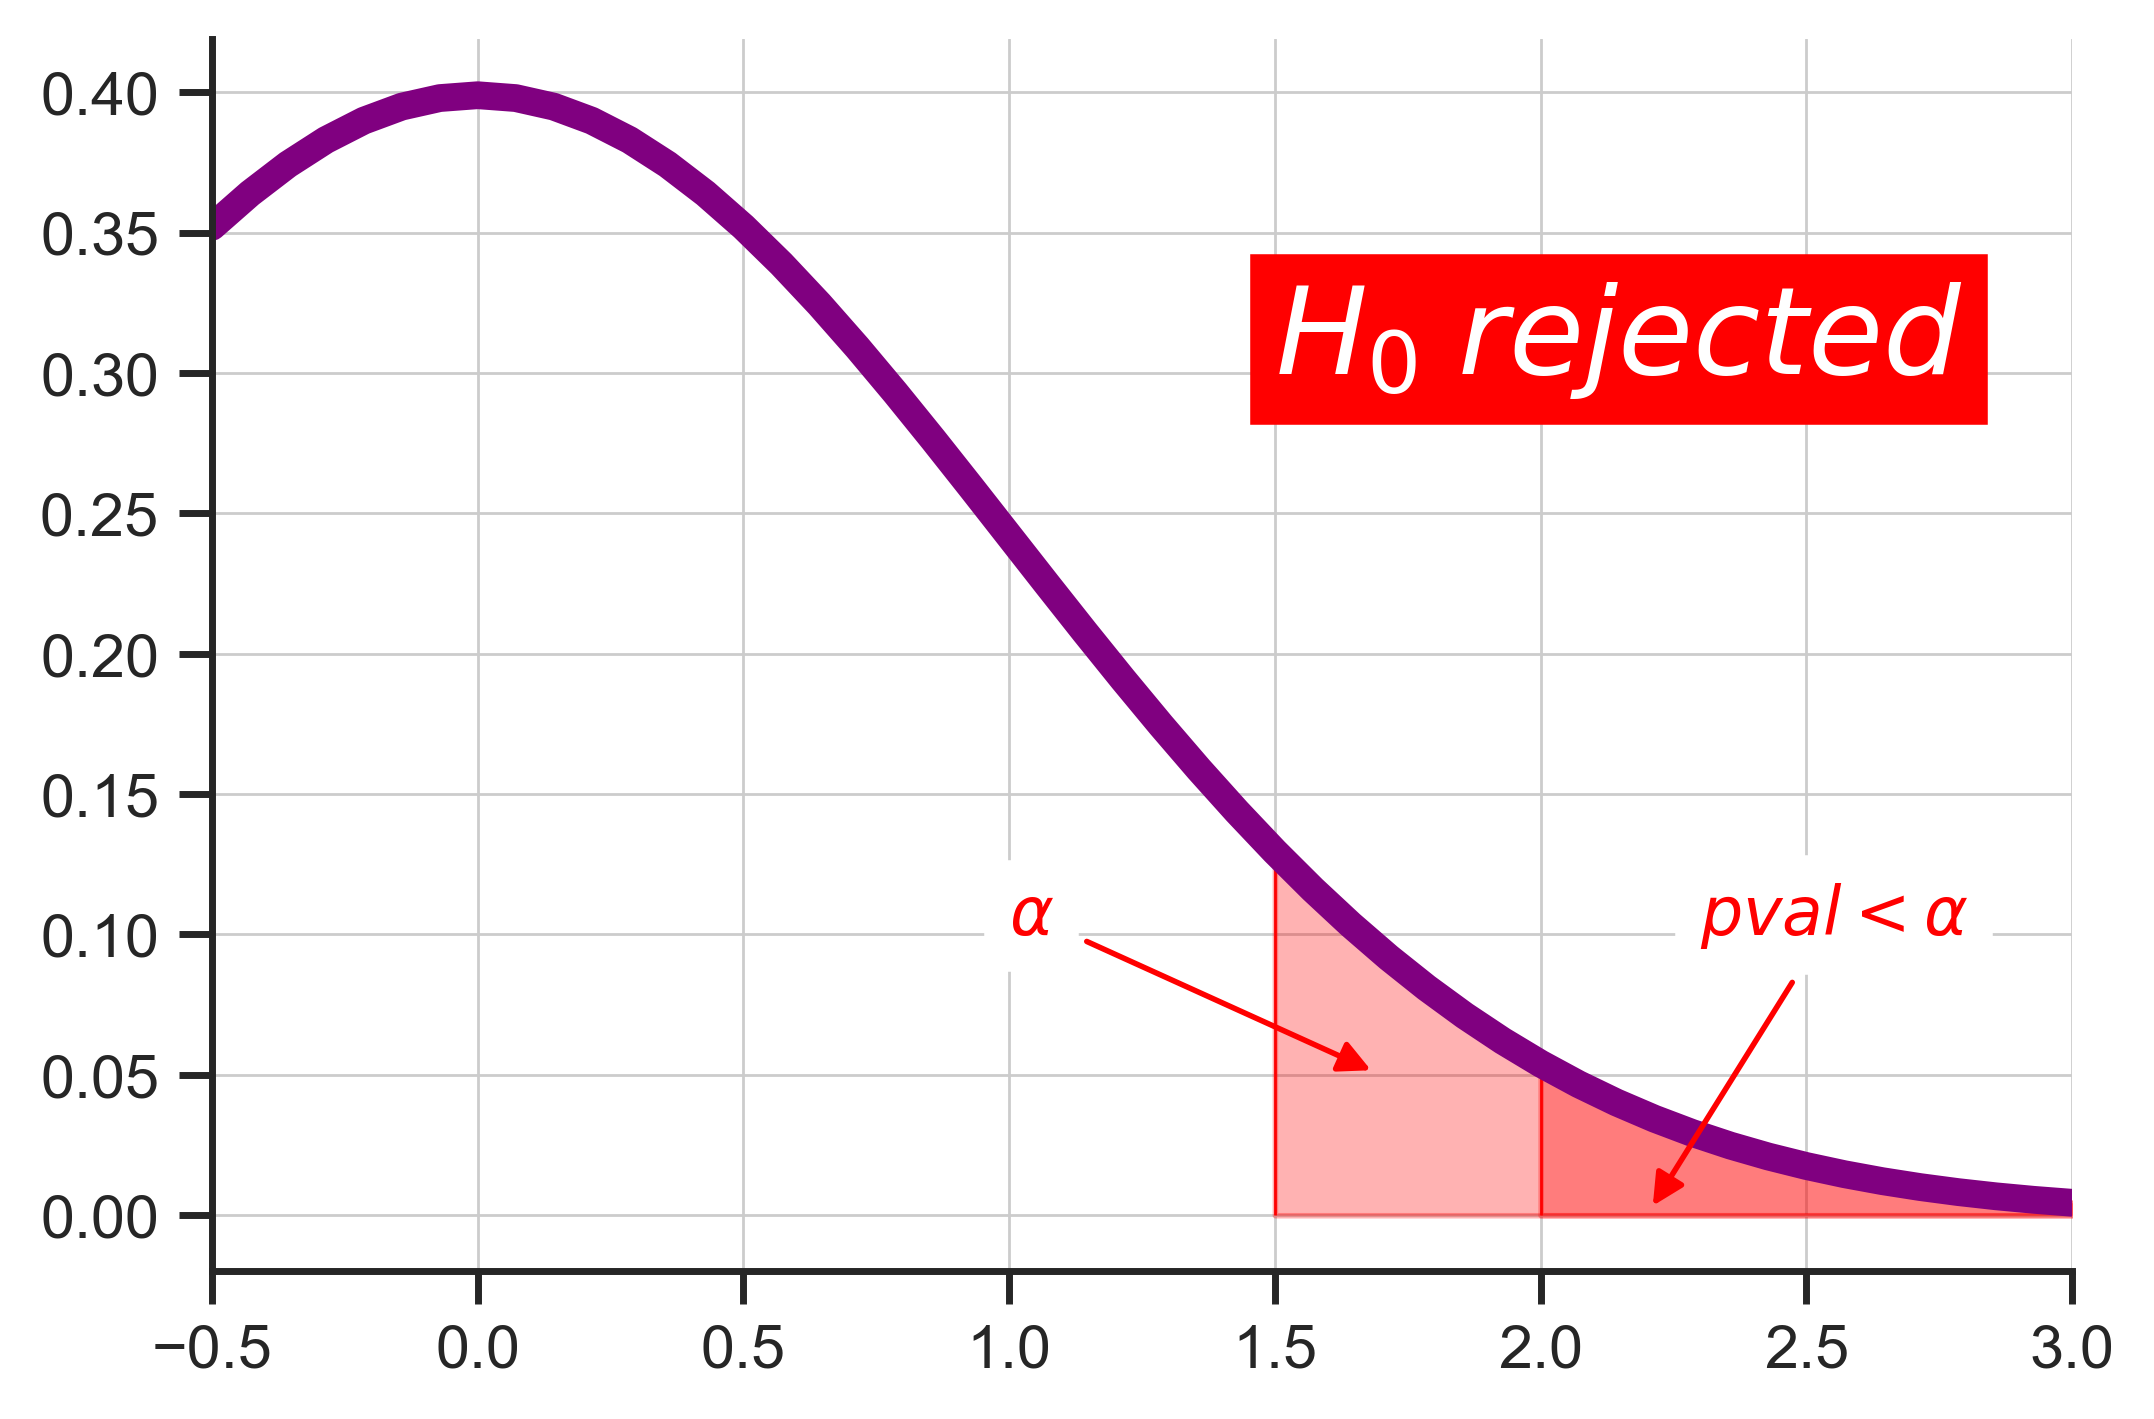

In [11]:
a, b = -0.5, 3
X = np.linspace(a, b)
x = [2, 1.5]  # для моделирования
y = [norm.pdf(val) for val in x]

plt.figure(figsize=(6,4))
plt.vlines(x, 0, y, color='r', lw=0.5)
plt.plot(X, norm.pdf(X), c='purple', lw=5)

for space in np.linspace(x, b).T:
    plt.fill_between(space, norm.pdf(space), 0, color='r', alpha=0.3)

plt.annotate('$pval<\\alpha$', xy=(2.2, 0), xytext=(2.3, 0.1),
             c='r', arrowprops=dict(arrowstyle= '-|>', color='r'),
             backgroundcolor='w')
plt.annotate('$\\alpha$', xy=(1.7, 0.05), xytext=(1, 0.1), 
             c='r', arrowprops=dict(arrowstyle= '-|>', color='r'),
             backgroundcolor='w')
plt.annotate('$H_0\;rejected$', xy=(1.5, 0.3), fontsize=22, c='w',
             backgroundcolor='r')
plt.xlim(a, b)
plt.grid(lw=0.5)
plt.show()

***
#### <a id='toc1_3_1_2_'></a>[__Ошибка 1-го рода, ошибка 2-го рода. Мощность статистического критерия. p-value__](#toc0_)

__p-значение__ статистики это вероятность получить такое же или более экстремальное значение статистики. Под экстремальным понимается _настойчивее свидетельствующее против $H_0$._

Пусть $F$ — функция распределения статистики теста.
* Если гипотеза правосторонняя, то p-значение статистики $x$ это $1-F(x)$.
* Если гипотеза левосторонняя, то p-значение статистики $x$ это $F(x)$. 
* Если гипотеза двусторонняя и статистика попала в правый луч критического множества, то p-значение статистики $x$ это $2 (1-F(x))$.
* Если гипотеза двусторонняя и статистика попала в левый луч критического множества, то p-значение статистики $x$ это $2 F(x)$.

Допустить __ошибку первого рода__ это отвергнуть $H_0$ при условии, что $H_0$​ верна. Вероятность совершить ошибку первого рода в статистическом тесте равна уровню значимости теста $\alpha$.

Допустить __ошибку второго рода__ это принять $H_0$​ при условии, что верна $H_1$​. 

Вернемся к примеру с пищевой добавкой для мышей. Распределение статистики в случае верной $H_1$​, т.е. при условии, что все $x_i$​ имеют распределение $N(24,25)$, а не $N(20,25)$, – $N \left( \frac{\Delta \mu}{\sigma / \sqrt{n}},1 \right) = N \left( \frac{24-20}{5 / \sqrt{10}},1 \right) \approx N(2.52,1)$:

$$\frac{x_1+\ldots+x_{10}}{10} \sim N \left( \frac{240}{10}, \frac{250}{10^2} \right) = N(24,2.5)$$

$$\left( \frac{x_1+\ldots+x_{10}}{10} - 20 \right) \sim N(4,2.5)$$

$$T(x_1,\ldots,x_{10}) = \left( \frac{\frac{x_1+\ldots+x_{10}}{10} - 20}{5 / \sqrt{10}} \right) \sim N(2.52,1)$$

In [12]:
norm().ppf(0.95)

1.6448536269514722

Ясно, что при верной $H_1$​ ошибка второго рода $\beta$ происходит тогда, когда $T$ принимает значение меньше $1.64$ – ведь именно в этих случаях мы принимаем гипотезу $H_0$​.

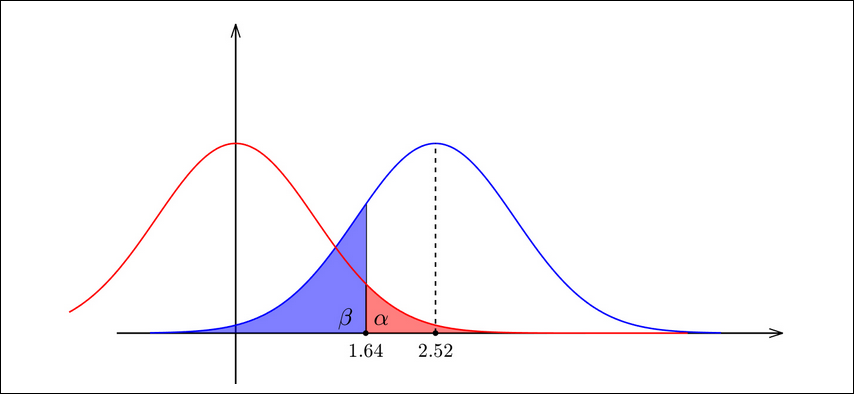

Число $(1-\beta)$ называют __мощностью статистического критерия__. Это вероятность отвергнуть неверную нулевую гипотезу.

In [13]:
1 - norm(loc=2.52).cdf(1.64)  # norm(loc=2.52).sf(1.64)

0.8105703452232879

***
#### <a id='toc1_3_1_3_'></a>[__I.1.2. Сравнение средних двух выборок: двухвыборочный z-тест__](#toc0_)

$H_0$: первая выборка из $N(\mu,\sigma^2_1)$, вторая из $N(\mu,\sigma^2_2)$, $\mu$ неизвестно, $\sigma^2_1$ и $\sigma^2_2$ известны.

$H_1$: первая выборка из $N(\mu_1,\sigma^2_1)$, вторая из $N(\mu_2,\sigma^2_2),\;\mu_1 \ne \mu_2$.

Пусть верна $H_0$. Поскольку выборки независимы, величины $\overline{x}_1 \sim N\left(\mu,\frac{\sigma^2_1}{n_1}\right)$​ и $\overline{x}_2 \sim N\left(\mu,\frac{\sigma^2_2}{n_2}\right)$​ независимы.

$$(\overline{x}_1 - \overline{x}_2) \sim N\left(\mu-\mu,\frac{\sigma^2_1}{n_1}+\frac{\sigma^2_2}{n_2}\right) \sim N\left(0,\frac{\sigma^2_1}{n_1}+\frac{\sigma^2_2}{n_2}\right)$$

Статистика: 
$$\frac{\overline{x}_1 - \overline{x}_2}{\sqrt{\frac{\sigma^2_1}{n_1} + \frac{\sigma^2_2}{n_2}}} \sim N(0,1)$$

В случае равных дисперсий:
$$\frac{\overline{x}_1 - \overline{x}_2}{\sigma\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} \sim N(0,1)$$

__Пример__.

In [14]:
X = np.array([[5, -2, 2, 0, 5, 6, -3, 4, 1],
              [3, 16, 7, 6, 13, 2, -5, 14, 7]])

In [15]:
# статистика руками
f = lambda sample: sample.var(ddof=1) / sample.size
np.subtract(*X.mean(axis=1)) / np.sqrt(np.apply_along_axis(f, 1, X).sum())

-2.031856384435789

Statsmodels, двухвыборочный двусторонний z-test. По умолчанию __`alternative="two-sided"`__: гипотеза $H_1$: _средние выборок не равны_ реализована как _разница средних не равна параметру_ __`value`__, который по умолчанию $0$.

In [16]:
stat, pval = ztest(*X)

In [17]:
stat

-2.0318563844357893

In [18]:
pval

0.04216819709715596

Смысл p-value в двустороннем тесте через взаимообратные функции percent point function и функцию распределения cumulative distribution function:

In [19]:
norm.ppf(pval / 2)

-2.0318563844357893

In [20]:
norm.cdf(stat) * 2

0.04216819709715596

***
### <a id='toc1_3_2_'></a>[__I.2. Дисперсия неизвестна: t-тест (t-критерий Стьюдента)__](#toc0_)

* Точечная оценка среднего:
$$\overline{x} = \frac{x_1+\ldots+x_n}{n}$$

* Доверительный интервал для среднего:
$$\biggl[\overline{x} - t_{\frac{1+\alpha}{2},(n-1)}\cdot\sqrt{\overline{\sigma}^2/n},\;\overline{x} - t_{\frac{1-\alpha}{2},(n-1)}\cdot\sqrt{\overline{\sigma}^2/n}\biggr],$$

$$\overline{\sigma}^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \overline{x})^2$$

См. _Интервальная оценка среднего при неизвестной дисперсии_ в [__stats_various.ipynb__](https://github.com/EvgenyMeredelin/math-for-data-science/blob/main/stats_various.ipynb)

***
#### <a id='toc1_3_2_1_'></a>[__I.2.1. Сравнение среднего с константой: одновыборочный t-тест__](#toc0_)

Статистика:
$$\frac{\overline{x} - \mu_0}{\sqrt{\overline{\sigma}^2/n}} \sim t_{(n-1)}$$

[__scipy.stats.ttest_1samp__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.ttest_1samp.html#scipy-stats-ttest-1samp)

***
#### <a id='toc1_3_2_2_'></a>[__I.2.2. Сравнение средних двух выборок: двухвыборочный t-тест, _равные_ дисперсии__](#toc0_)

$H_0$: обе выборки получены из одного распределения $N(\mu,\sigma^2)$; и $\mu$, и $\sigma^2$ неизвестны.

$H_1$: выборки получены из $N(\mu_1,\sigma^2),\;N(\mu_2,\sigma^2),\;\mu_1 \ne \mu_2$.

Статистика:
$$\frac{\overline{x}_1 - \overline{x}_2}{\sqrt{\frac{1}{n_1} + \frac{1}{n_2}}} \cdot \sqrt{\frac{n_1+n_2-2}{\overline{\sigma}^2_1(n_1-1)+\overline{\sigma}^2_2(n_2-1)}} \sim t_{(n_1+n_2-2)}$$

[__scipy.stats.ttest_ind__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.ttest_ind.html#scipy-stats-ttest-ind)

***
#### <a id='toc1_3_2_3_'></a>[__I.2.3. Сравнение средних двух выборок: двухвыборочный t-тест, _различные_ дисперсии__](#toc0_)

$H_0$: первая выборка получена из $N(\mu,\sigma^2_1)$, вторая — из $N(\mu,\sigma^2_2)$.

$H_1$: выборки получены из $N(\mu_1,\sigma^2_1),\;N(\mu_2,\sigma^2_2),\;\mu_1 \ne \mu_2$.

Статистика:

$$\Large \frac{\overline{x}_1 - \overline{x}_2}{\sqrt{\frac{\overline{\sigma}^2_1}{n_1} + \frac{\overline{\sigma}^2_2}{n_2}}} \sim t_{\nu}, \quad \nu=\frac{\left(\frac{\overline{\sigma}^2_1}{n_1} + \frac{\overline{\sigma}^2_2}{n_2}\right)^2}{\frac{\left(\frac{\overline{\sigma}^2_1}{n_1}\right)^2}{n_1-1} + \frac{\left(\frac{\overline{\sigma}^2_2}{n_2}\right)^2}{n_2-1}}.$$

[__scipy.stats.ttest_ind__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.ttest_ind.html#scipy-stats-ttest-ind) | [__Welch's t-test__](https://en.wikipedia.org/wiki/Welch%27s_t-test)

***
#### <a id='toc1_3_2_4_'></a>[__F-тест Фишера на равенство дисперсий__](#toc0_)

Перед выбором между __I.2.2__ и __I.2.3__ рекомендуется провести F-тест Фишера на равенство дисперсий:

$H_0$: обе выборки получены из распределений с одной и той же дисперсией $\sigma$.

$H_1$: выборки получены из распределений с разными дисперсиями $\sigma_1$ и $\sigma_2$.

Статистика — отношение несмещенных выборочных дисперсий:
$$\frac{\overline{\sigma}^2_1}{\overline{\sigma}^2_2}$$

[__stackoverflow__](https://stackoverflow.com/questions/21494141/how-do-i-do-a-f-test-in-python) | [__scipy.stats.f__](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f.html#scipy-stats-f)

***
#### <a id='toc1_3_2_5_'></a>[__Проверка на нормальность: тест Шапиро–Уилка__](#toc0_)

[__scipy.stats.shapiro__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.shapiro.html#scipy-stats-shapiro)

***
## <a id='toc1_4_'></a>[__II. Тесты для случайных величин, распределенных не нормально__](#toc0_)

* Точечная оценка среднего:

$$\overline{x} = \frac{x_1+\ldots+x_n}{n}$$

* Интервальная оценка среднего (внимание: не доверительный интервал): [__scipy.stats.bootstrap__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.bootstrap.html#scipy-stats-bootstrap)

***
### <a id='toc1_4_1_'></a>[__II.1. Сравнение среднего выборки с константой__](#toc0_)

Дана выборка $x_1,\ldots,x_n$ из неизвестного распределения с неизвестным средним $\mu$.

$H_0$: $\mu = \mu_0$.

$H_1$: $\mu \ne \mu_0$.

Строгий тест невозможен. На практике: $\mu_0 \in \text{0.95 bootstrap interval}$ в пользу $H_0$. 

***
### <a id='toc1_4_2_'></a>[__II.2. Сравнение средних двух выборок: U-тест Манна-Уитни__](#toc0_)

$H_0$: выборки получены из одного распределения.

$H_1$: выборки получены из разных распределений.

В пользу общности распределения говорит более высокая степень взаимопроникновения, перемешанности выборок. Количественную оценку перемешанности выборок дает __U-тест Манна-Уитни__.

Даны выборки $x_1,\ldots,x_{n_1}$ и $y_1,\ldots,y_{n_2}$ и функция $S$, определенная так:
$$S(x_i,y_j) = \begin{cases}1, & x_i > y_j \\
\frac{1}{2}, & x_i = y_j \\
0, & x_i < y_j\end{cases}$$

Тогда статистика U-теста Манна-Уитни это число

$$\sum_{i=1}^{n_1}\left(\sum_{j=1}^{n_2}S(x_i,y_j)\right)$$

Значение статистики лежит в интервале $[0,\;n_1 n_2]$, где $0$ соответствует ситуации, когда все $x_i$ лежат левее $y_j$, $n_1 n_2$ — все $x_i$ лежат правее $y_j$. Значение статистики, близкое к $n_1 n_2 / 2$, свидетельствует в пользу $H_0$.

[__scipy.stats.mannwhitneyu__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.mannwhitneyu.html#scipy-stats-mannwhitneyu)

__Пример__.

In [21]:
fields = ['statistic', 'h0_point']
MWUHandmadeResult = namedtuple('MWUHandmadeResult', fields)

In [22]:
def mwu_handmade(sample1, sample2):
    statistic = 0
    for x, y in product(sample1, sample2):
        if x > y:
            statistic += 1
        if x == y:
            statistic += 0.5
    h0_point = len(sample1) * len(sample2) / 2    
    return MWUHandmadeResult(statistic, h0_point)

In [23]:
x = [15, 7, 12]
y = [4, 10, 1, 6]

In [24]:
mwu_handmade(x, y)

MWUHandmadeResult(statistic=11, h0_point=6.0)

In [25]:
mannwhitneyu(x, y)

MannwhitneyuResult(statistic=11.0, pvalue=0.11428571428571428)

In [26]:
x = [11, 5, 1]
y = [7, 0, 10, 3]

In [27]:
mwu_handmade(x, y)

MWUHandmadeResult(statistic=7, h0_point=6.0)

In [28]:
mannwhitneyu(x, y)

MannwhitneyuResult(statistic=7.0, pvalue=0.8571428571428571)

Хотя это не соответствует изначальному назначению и не вполне корректно, U-тест Манна-Уитни часто применяют для сравнения средних: если статистика сильно отклоняется вверх, то полагают, что у первой выборки среднее больше.

У такого применения теста есть проблема. Тест нечувствителен к тому, насколько сравниваемые элементы выборок отличаются друг от друга по абсолютной величине, а значит, в случае редких выбросов, косвенное суждение о соотношении средних лишь на основе статистики будет ошибаться. Проблема решается разбиением каждой выборки на одинаковое количество $n$ усредняемых групп. А с полученными $n+n$ средними работают по обычному сценарию. 

Критерий Манна-Уитни также называют критерием суммы рангов Уилкоксона (и __критерием Манна-Уитни-Уилкоксона__).

Объединим элементы обеих выборок в один сортированный по неубыванию массив. Будем считать, что никакие элементы массива не совпадают. Ранг наименьшего элемента $1$, ранг наибольшего $(n_1 + n_2)$. Обозначим за $R_1$​ сумму рангов элементов первой выборки. Тогда

$$R_1 - \frac{n_1(n_1 + 1)}{2} = \sum_{i=1}^{n_1}\left(\sum_{j=1}^{n_2}S(x_i,y_j)\right)$$

Для любого натурального $k$ сумма чисел $1,2,\ldots,k$ равна $\frac{k(k+1)}{2}$.

[__scipy.stats.wilcoxon__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.wilcoxon.html#scipy-stats-wilcoxon) | [__scipy.stats.ranksums__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.ranksums.html#scipy-stats-ranksums)

__Пример__.

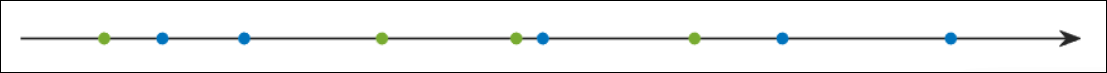

In [29]:
mix = np.array(['g', 'b', 'b', 'g', 'g', 'b', 'g', 'b', 'b'])
# green_mask = mix == 'g'
# green = np.nonzero(green_mask)[0] + 1
# blue = np.nonzero(~green_mask)[0] + 1
green = np.where(mix == 'g')[0] + 1
green.sum() - np.arange(1, green.size + 1).sum()

7

In [30]:
blue = np.where(mix == 'b')[0] + 1
mannwhitneyu(green, blue)

MannwhitneyuResult(statistic=7.0, pvalue=0.5555555555555556)

***
## <a id='toc1_5_'></a>[__III. Бинарные величины__](#toc0_)

Дана выборка из распределения Бернулли с неизвестным параметром $p$.

Точечная оценка среднего:
$$\overline{p} = \frac{x_1+\ldots+x_n}{n}$$ 

Нельзя предъявить процедуру, которая дает доверительный интервал для среднего с гарантиями. Если исходить из допущений:

* выборка достаточно большая, чтобы было выполнена ЦПТ, тогда выборочное среднее $\overline{p}$ имеет нормальное распределение,

* выборка достаточно большая, чтобы $\sigma^2 \approx \overline{\sigma}^2 = \overline{p}(1-\overline{p})$, и тогда дисперсия среднего в $n$ раз меньше, $\frac{\overline{p}(1-\overline{p})}{n}$, 

то доверительный интервал:

$$\Biggl[\overline{p} - \overbrace{q_{\frac{1+\alpha}{2}}}^{N(0,1)} \cdot \sqrt{\frac{\overline{p}(1-\overline{p})}{n}},\;\overline{p} - q_{\frac{1-\alpha}{2}} \cdot \sqrt{\frac{\overline{p}(1-\overline{p})}{n}}\Biggr]$$

__Пример__.

In [31]:
def bernoulli_conf_interval(sample, *, conf_level):
    p = np.mean(sample)
    sigma = np.sqrt(p * (1 - p) / len(sample))
    return tuple(p - norm.ppf((1 + j*conf_level) / 2) * sigma for j in (1, -1))

In [32]:
bernoulli_conf_interval([0]*30 + [1]*70, conf_level=0.95)

(0.6101831668145794, 0.7898168331854205)

Однако если $\overline{p}$ близко к $0$ или $1$, то
* $\bigl[0,\frac{3}{n}\bigr],\;\overline{p}=0$
* $\bigl[1-\frac{3}{n},1\bigr],\;\overline{p}=1.$

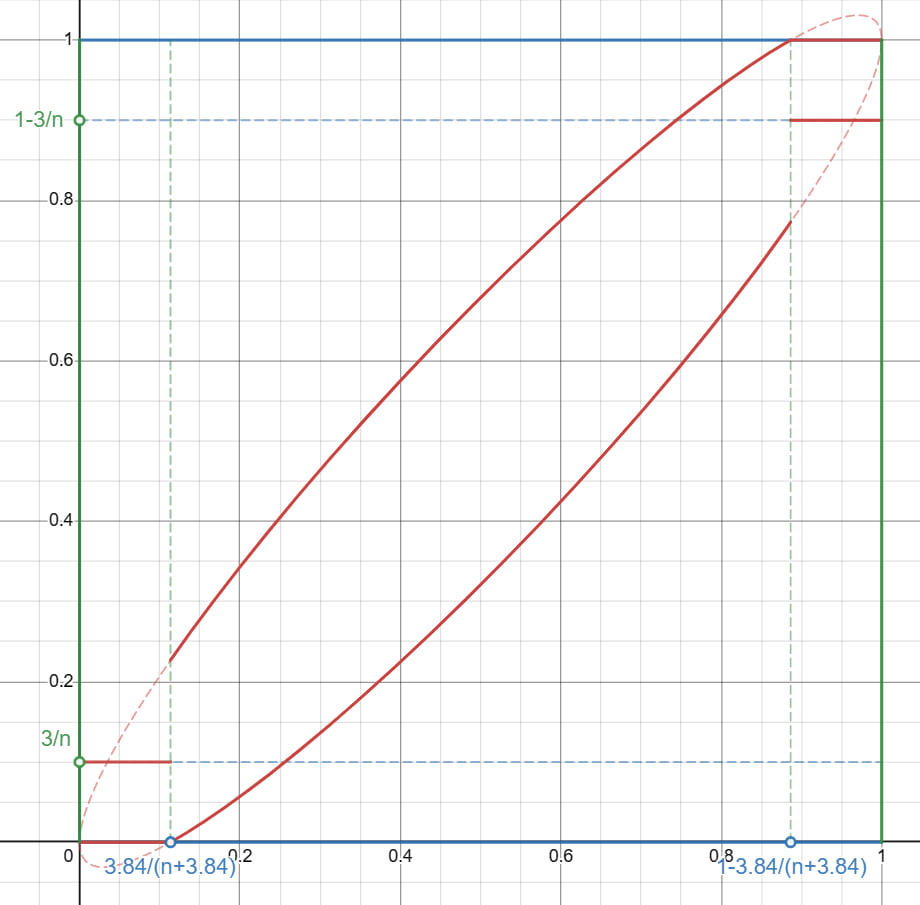
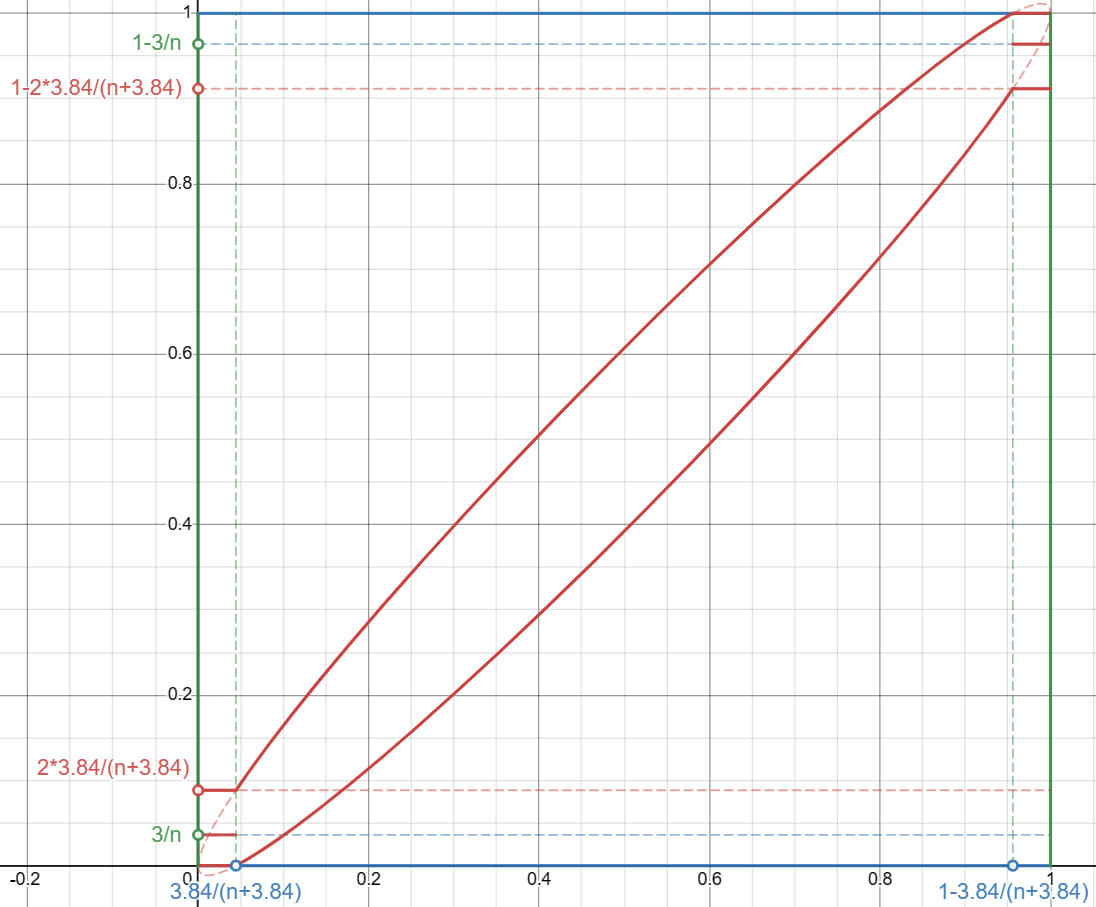

$\overline{p}$, при котором левая граница становится отрицательной:

In [33]:
p, z, n = sym.symbols('p z n')
sym.solve(p**2 - z**2 * p*(1 - p)/n, p)

[0, z**2/(n + z**2)]

Соответственно, критерий зануления левой границы:
$$\overline{p} \leqslant \frac{z^2}{z^2 + n}$$

Правая граница определяется из соображения симметричности интервала: если левая граница обнулилась при $\overline{p} = \frac{z^2}{z^2 + n}$, то правая, отстоящая на два полуинтервала, равна 
$$\frac{2z^2}{z^2 + n}.$$

$\overline{p}$, при котором правая граница становится больше единицы, можно определить симметричностью "выпирания" эллипса из квадрата с единичной стороной, или, чуть подробнее:

$$\overline{p} - z_{\frac{1-\alpha}{2}} \sqrt{\frac{\overline{p}(1-\overline{p})}{n}} = \overline{p} + z_{\frac{1+\alpha}{2}} \sqrt{\frac{\overline{p}(1-\overline{p})}{n}} = \overline{p} + \frac{z^2}{z^2 + n} = 1$$

Соответственно, критерий "объединичивания" правой границы:

$$\overline{p} \geqslant 1 - \frac{z^2}{z^2 + n}$$

Тогда левая граница, в силу той же симметричности интервала относительно $\overline{p}$:
$$1 - \frac{2z^2}{z^2 + n}.$$

***
### <a id='toc1_5_1_'></a>[__III.1. Сравнение среднего выборки с константой__](#toc0_)

***
#### <a id='toc1_5_1_1_'></a>[__III.1.1. Приближенное решение__](#toc0_)

Дана выборка $x_1,\ldots,x_n$ из распределения Бернулли с неизвестным параметром $p$. 

$H_0$: $p = p_0$.

$H_1$: $p \ne p_0$.

При $H_0$ среднее $x_i$ равно $p_0$, дисперсия $x_i$ равна $p_0(1-p_0)$. Значит, дисперсия $\overline{p} = \frac{x_1+\ldots+x_n}{n}$ равна 

$$\frac{p_0(1-p_0)}{n}.$$

Будем считать, что выборка достаточно большая, чтобы ЦПТ была выполнена. Тогда при $H_0$ выборочное среднее $\overline{p} \sim N\left(p_0,\frac{p_0(1-p_0)}{n}\right)$. Применяем z-тест для статистики

$$\frac{\overline{p}-p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}} \sim N(0,1)$$

***
#### <a id='toc1_5_1_2_'></a>[__III.1.2. Точное решение__](#toc0_)

При $H_0$ $p=p_0$. $\overline{p}$ имеет биномиальное распределение. Какова вероятность того, что $\overline{p}=\frac{k}{n}$​? Она равна вероятности того, что среди $n$ элементов выборки $k$ окажутся равны $1$:
$$\overline{p} = \binom{n}{k}\,p^k_0\,(1-p_0)^{n-k}$$

__Пример__.

In [34]:
fields = ['conf_interval', 'k', 'decision']
BinomTestResult = namedtuple('BinomTestResult', fields)

In [35]:
def binom_test(sample, *, p0, conf_level):
    conf_interval = binom.interval(conf_level, len(sample), p0)
    left, right = conf_interval
    k = np.count_nonzero(sample)
    decision = 'H0' if left <= k <= right else 'H1'
    return BinomTestResult(conf_interval, k, decision)

In [36]:
binom_test([0]*30 + [1]*70, p0=0.6, conf_level=0.95)

BinomTestResult(conf_interval=(50.0, 69.0), k=70, decision='H1')

Дана выборка из $30$ нулей и $70$ единиц. $H_0$: выборка получена из биномиального распределения со средним $p_0=0.6$. $H_1$: выборка получена из биномиального распределения со средним, отличным от $p_0=0.6$. 

По $p_0$, размеру выборки и уровню доверия $\alpha$ строится доверительный интервал для числа успехов. Получилось, что при данных условиях число успехов должно лежать в интервале $[50,69]$, а в выборке число успехов $70$. Следовательно, принимается $H_1$. 

In [37]:
bin_rv = binom(100, 0.6)
bin_rv.interval(0.95)

(50.0, 69.0)

In [38]:
# смысл границ интервала
bin_rv.ppf(0.025), bin_rv.ppf(0.975)

(50.0, 69.0)

In [39]:
bin_rv.cdf(69) - bin_rv.cdf(50)  # approx 95%

0.9481179791264979

Посмотрим, лучший ли это вариант с точки зрения близости к $95\%$:

In [40]:
L, R = bin_rv.interval(0.95)
L, R

(50.0, 69.0)

In [41]:
L, R = ([bound + delta for delta in (-1, 0, 1)] for bound in (L, R))
L, R

([49.0, 50.0, 51.0], [68.0, 69.0, 70.0])

In [42]:
def calc_error(left, right, conf_level=0.95):
    return abs(bin_rv.cdf(right) - bin_rv.cdf(left) - conf_level)

In [43]:
fields = ['error', 'left', 'right']
CalcErrorResult = namedtuple('CalcErrorResult', fields)

In [44]:
results = [CalcErrorResult(calc_error(*bounds), *bounds) 
           for bounds in product(L, R)]
results.sort()
results

[CalcErrorResult(error=0.0018820208735020882, left=50.0, right=69.0),
 CalcErrorResult(error=0.006609570738005832, left=49.0, right=68.0),
 CalcErrorResult(error=0.007076738419868889, left=51.0, right=70.0),
 CalcErrorResult(error=0.008125484012259876, left=50.0, right=70.0),
 CalcErrorResult(error=0.008455490380345432, left=49.0, right=69.0),
 CalcErrorResult(error=0.016947081991853352, left=50.0, right=68.0),
 CalcErrorResult(error=0.017084243305630853, left=51.0, right=69.0),
 CalcErrorResult(error=0.018462995266107396, left=49.0, right=70.0),
 CalcErrorResult(error=0.03214930442398212, left=51.0, right=68.0)]

***
### <a id='toc1_5_2_'></a>[__III.2. Сравнение средних двух выборок__](#toc0_)

Даны две выборки размера $n_1$​ и $n_2$​ соответственно. Первая выборка из распределения Бернулли с неизвестным средним $p_1$​, вторая из распределения Бернулли с неизвестным средним $p_2$​.

$H_0$: $p_1 = p_2 = p$ (выборки получены из одного распределения).

$H_1$: $p_1 \ne p_2$ (выборки получены из разных распределений).

Если сработала ЦПТ, величина $(\overline{p}_1-\overline{p}_2) \sim N$. При $H_0$:

$$\mathsf{E}(\overline{p}_1-\overline{p}_2) = 0$$ 

$$\mathsf{D}(\overline{p}_1) = \frac{p(p-1)}{n_1},\,\mathsf{D}(\overline{p}_2) = \frac{p(p-1)}{n_2} \Rightarrow$$

$$\mathsf{D}(\overline{p}_1-\overline{p}_2) = p(p-1)\left(\frac{1}{n_1} + \frac{1}{n_2}\right).$$

Дисперсия $p(p-1)$ неизвестна, оценить ее можно так. При $H_0$ выборки взяты из одного распределения, значит, разумно рассматривать две выборки как одну большую, и оценить дисперсию по ней. В обобщенной выборке $(n_1 + n_2)$ элементов и $(n_1\overline{p}_1 + n_2\overline{p}_2)$ единиц. Тогда

$$\overline{p} = \frac{(n_1\overline{p}_1 + n_2\overline{p}_2)}{(n_1 + n_2)}$$

Значит, статистика

$$\frac{\overline{p}_1-\overline{p}_2}{\sqrt{\overline{p}(\overline{p}-1)\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}} \sim N(0,1)$$

__Важно__. При построении теста использовались два предположения: ЦПТ выполнена, оценка дисперсии близка к истинной дисперсии. Значит, этот тест будет работать хорошо только если выборка достаточно большая и $\overline{p}_1$​ и $\overline{p}_1$​ не слишком близки к $0$ или $1$.

__Другие способы__. U-тест Манна-Уитни с группировкой, точный тест Фишера, критерий хи-квадрат.

[__scipy.stats.fisher_exact__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.fisher_exact.html#scipy-stats-fisher-exact)

***
### <a id='toc1_5_3_'></a>[__Tests for goodness of fit__](#toc0_)

***
#### <a id='toc1_5_3_1_'></a>[__Дискретный случай: критерий согласия хи-квадрат (критерий согласия Пирсона)__](#toc0_)

Дана выборка $x_1,\ldots,x_n$ и известное дискретное распределение $F$.

$H_0$: выборка получена из $F$.

$H_1$: выборка получена не из $F$.

$F$ задается $k$ парами {значение $a_i$: вероятность $p_i$}. Количество чисел $a_i$, ожидаемое в среднем в выборке: $np_i$, фактическое: $n_i$.

В качестве меры согласованности логично принять величину

$$\frac{(n_i - np_i)^2}{np_i} \sim N(0,\,1-p_i)$$

Тогда статистика критерия хи-квадрат:

$$\sum_{i=1}^{k}\frac{(n_i - np_i)^2}{np_i} \sim \chi^2_{k-1}$$

Большее значение статистики свидетельствует против $H_0$.

__Важно__. Критерий согласия хи-квадрат работает хорошо только при больших $n$, потому что при малых не работает ЦПТ, а потому распределение статистики плохо приближается распределением хи-квадрат.

[__scipy.stats.chisquare__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.chisquare.html#scipy-stats-chisquare)

__Пример__.

In [45]:
def chisqTest(sample, *, proba, alpha):
    counts = np.unique(sample, return_counts=True)[1]
    nxp = len(sample) * np.asarray(proba)
    statHandmade = ((counts - nxp)**2 / nxp).sum()
    statScipy, pvalue = chisquare(f_obs=counts, f_exp=nxp)
    assert np.isclose(statHandmade, statScipy)
    decision = 'H1' if pvalue < alpha else 'H0'
    fields = ['statHandmade', 'statScipy', 'pvalue', 'decision']
    stats = map(lambda s: round(s, 3), (statHandmade, statScipy))
    Result = namedtuple('Result', fields)
    return Result(*stats, pvalue, decision)

In [46]:
samples = [2,8,8,6,8,6,2,8,8,8], [6,6,8,6,6,6,2,6,6,6]
proba = [0.3, 0.2, 0.5]

In [47]:
for sample in samples:
    print_black(chisqTest(sample, proba=proba, alpha=0.05))

Result(statHandmade=0.533, statScipy=0.533, pvalue=0.7659283383646487, decision="H0")

Result(
    statHandmade=22.533, statScipy=22.533, pvalue=1.2792305934136418e-05, decision="H1"
)



***
#### <a id='toc1_5_3_2_'></a>[__Непрерывный случай: критерий Колмогорова-Смирнова__](#toc0_)

Дана выборка $x_1,\ldots,x_n$ и известное непрерывное распределение $F$.

$H_0$: выборка получена из $F$.

$H_1$: выборка получена не из $F$.

Пусть $x_1,\ldots,x_n$ это выборка из распределения $G$. __Эмпирическая (выборочная) функция распределения__ $\overline{G}$ это распределение дискретной случайной величины, равномерно распределенной на элементах выборки $x_1,\ldots,x_n$.

Для любого $x$ значение $\overline{G}(x)$ равно $\frac{k}{n}$, где $k$ это количество элементов выборки, которые меньше или равны $x$:

$$\overline{G}(x) := \frac{1}{n}\sum_{i=1}^n\textbf{1}_{x_i \leqslant x}$$

Статистика теста Колмогорова-Смирнова:

$$D_n := \sup_{x \in \mathsf{R}} |F(x) - \overline{F}(x)|$$

Если нулевая гипотеза выполнена, то при $n \to \infty$ распределение величины $\sqrt{n}D_n$​ стремится к распределению Колмогорова. Большее значение статистики свидетельствует против $H_0$. Критическое множество — одностороннее вида $[a,+\infty]$, где $a$ — квантиль распределения Колмогорова, деленный на $\sqrt{n}$.

[__statsmodels.distributions.empirical_distribution.ECDF__](https://www.statsmodels.org/dev/generated/statsmodels.distributions.empirical_distribution.ECDF.html#generated-statsmodels-distributions-empirical-distribution-ecdf--page-root) | [__seaborn.ecdfplot__](https://seaborn.pydata.org/generated/seaborn.ecdfplot.html#seaborn-ecdfplot) | [__scipy.stats.kstest__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest)

__Пример__.

In [48]:
sample = np.array([4,-1,7,4,2,5,3,2,4,4])

<Axes: ylabel='Density'>

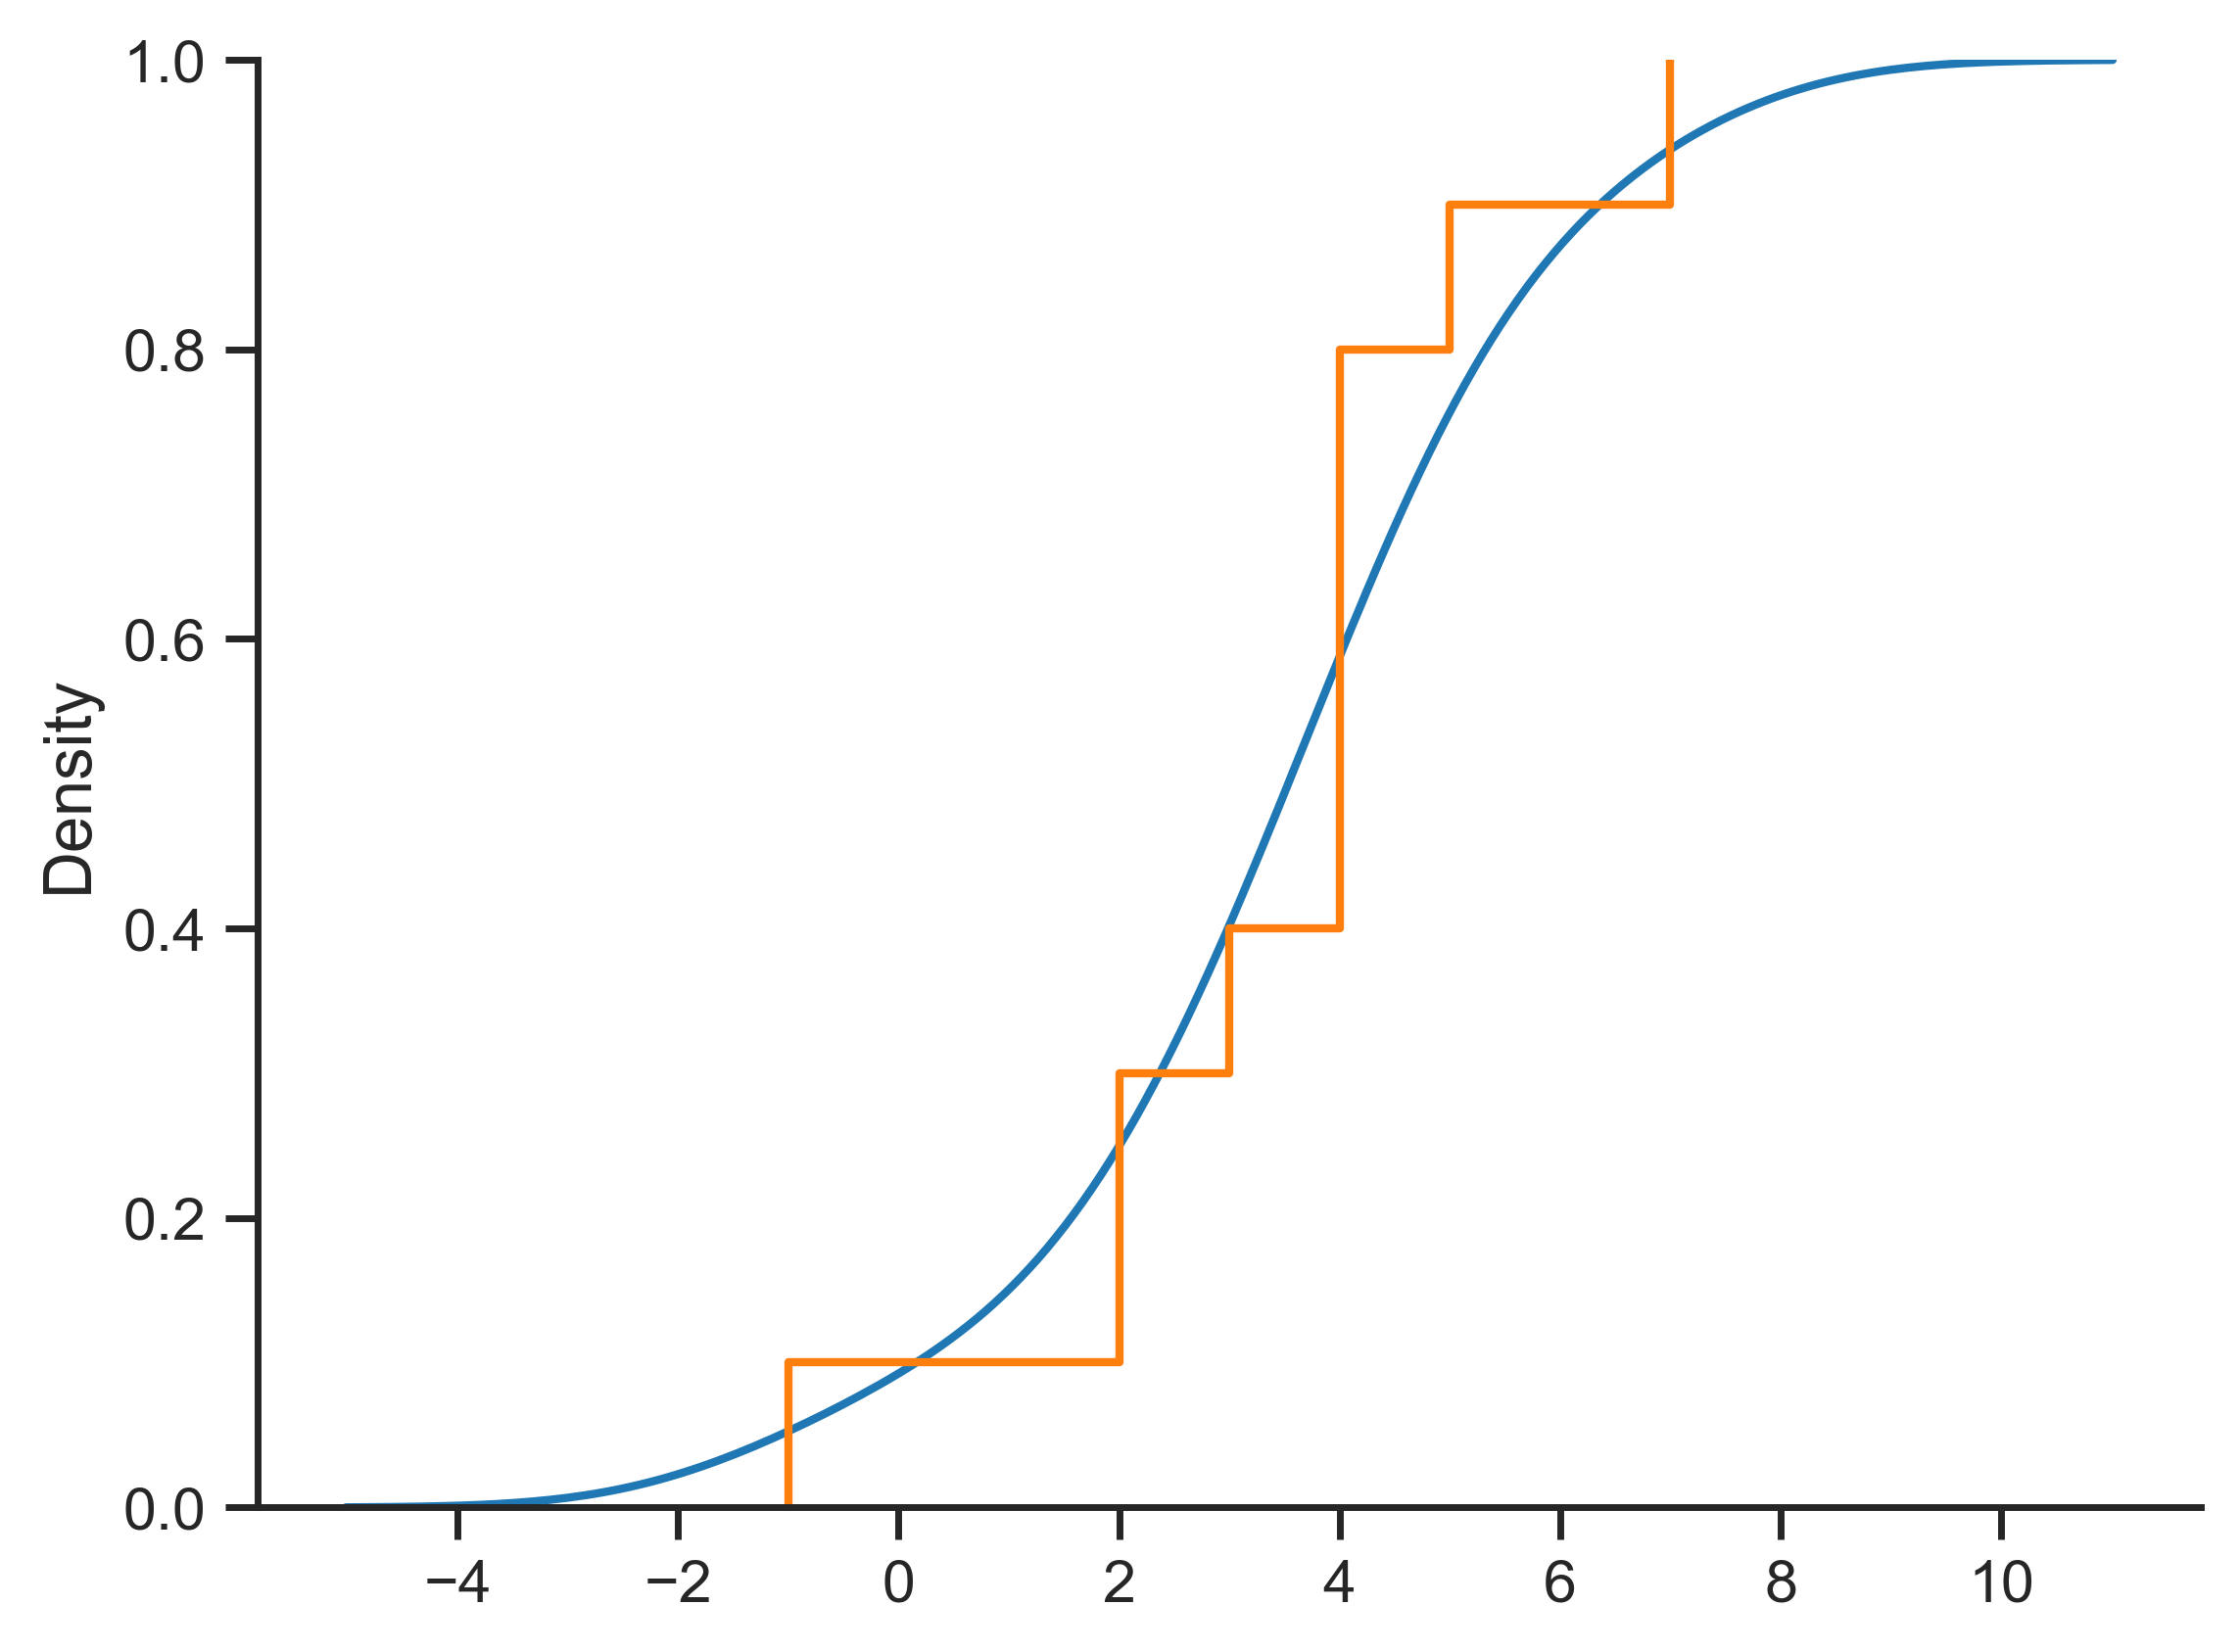

In [49]:
sns.kdeplot(sample, cumulative=True)
sns.ecdfplot(sample)

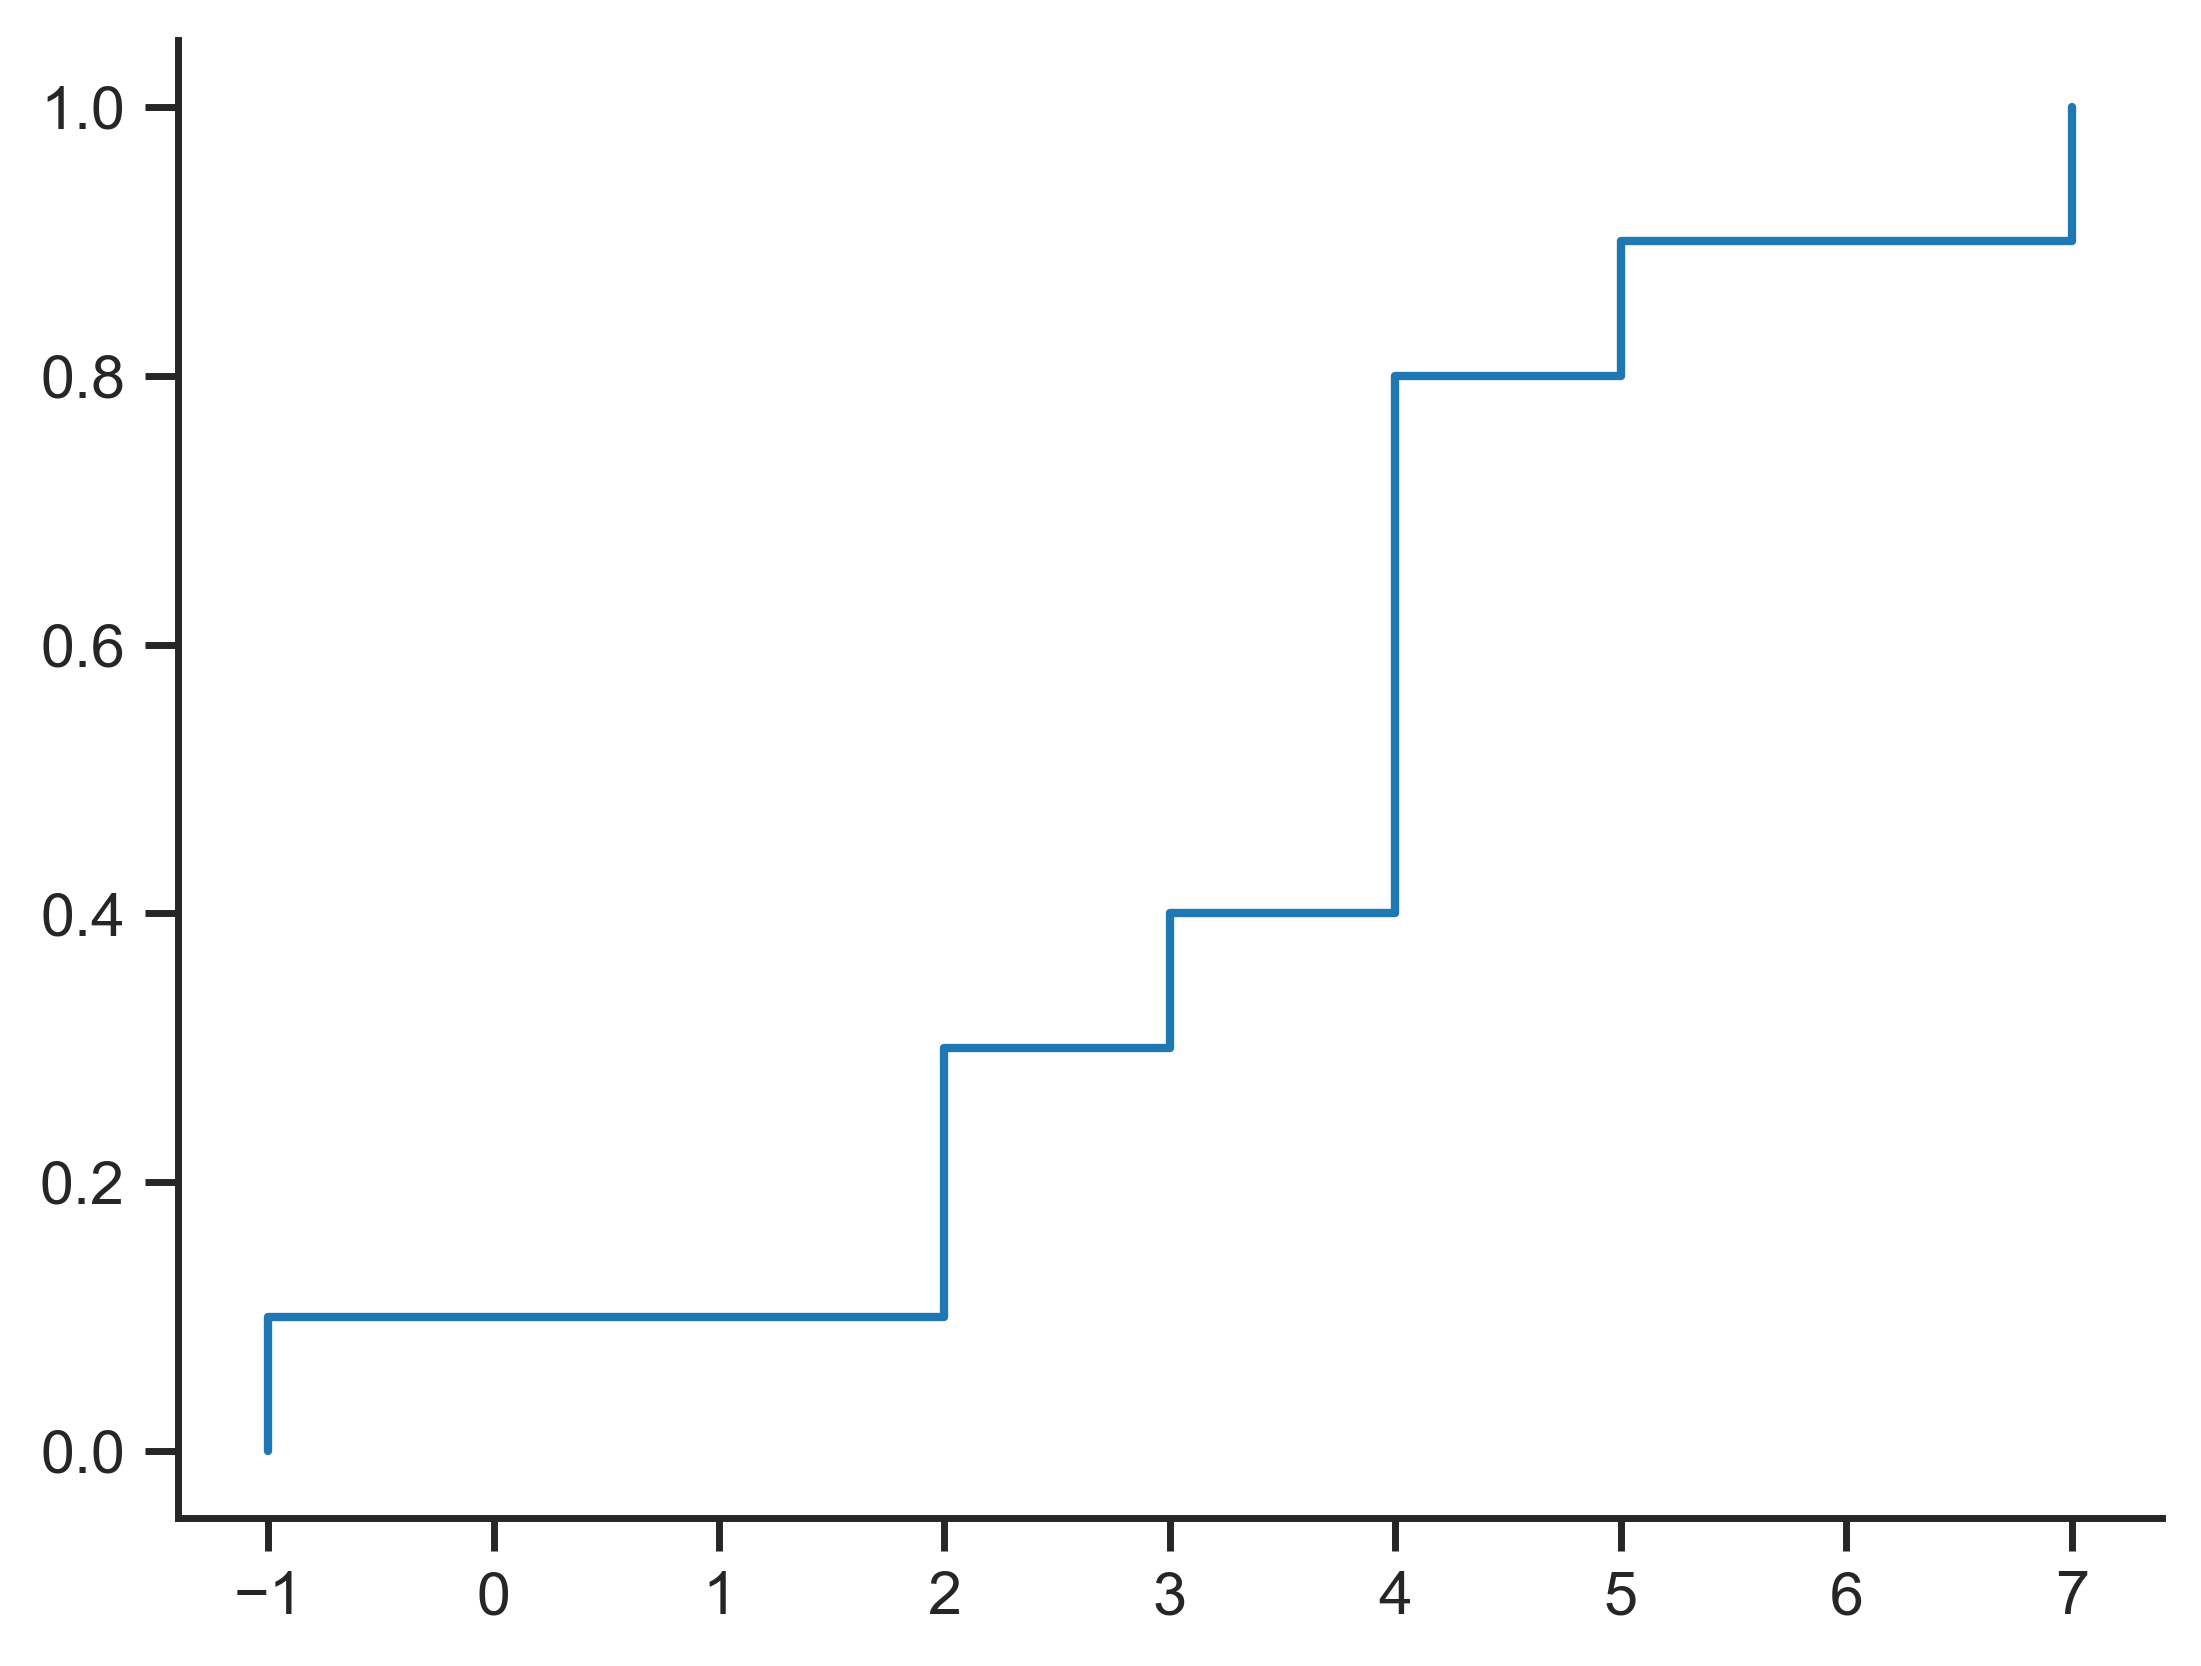

In [50]:
ecdf = ECDF(sample)
plt.step(ecdf.x, ecdf.y, where='post')
#plt.plot(ecdf.x, ecdf.y, drawstyle='steps-post')

Вероятности оптом из объекта класса ECDF:

In [51]:
tester = 2, 4
ecdf(tester)

array([0.3, 0.8])

То же руками, используя определение ECDF в точке как суммы индикаторов:

In [52]:
f = lambda x: (sample <= x).sum() / sample.size
np.vectorize(f)(tester)

array([0.3, 0.8])

__Пример__.

In [53]:
a, b = 0, 5
x = range(a-1, b+2)
unif = uniform(a, b-a)

sample = 2, 4, 4
ecdf = ECDF(sample)
y = ecdf(2), unif.cdf(4)

alpha = 0.05

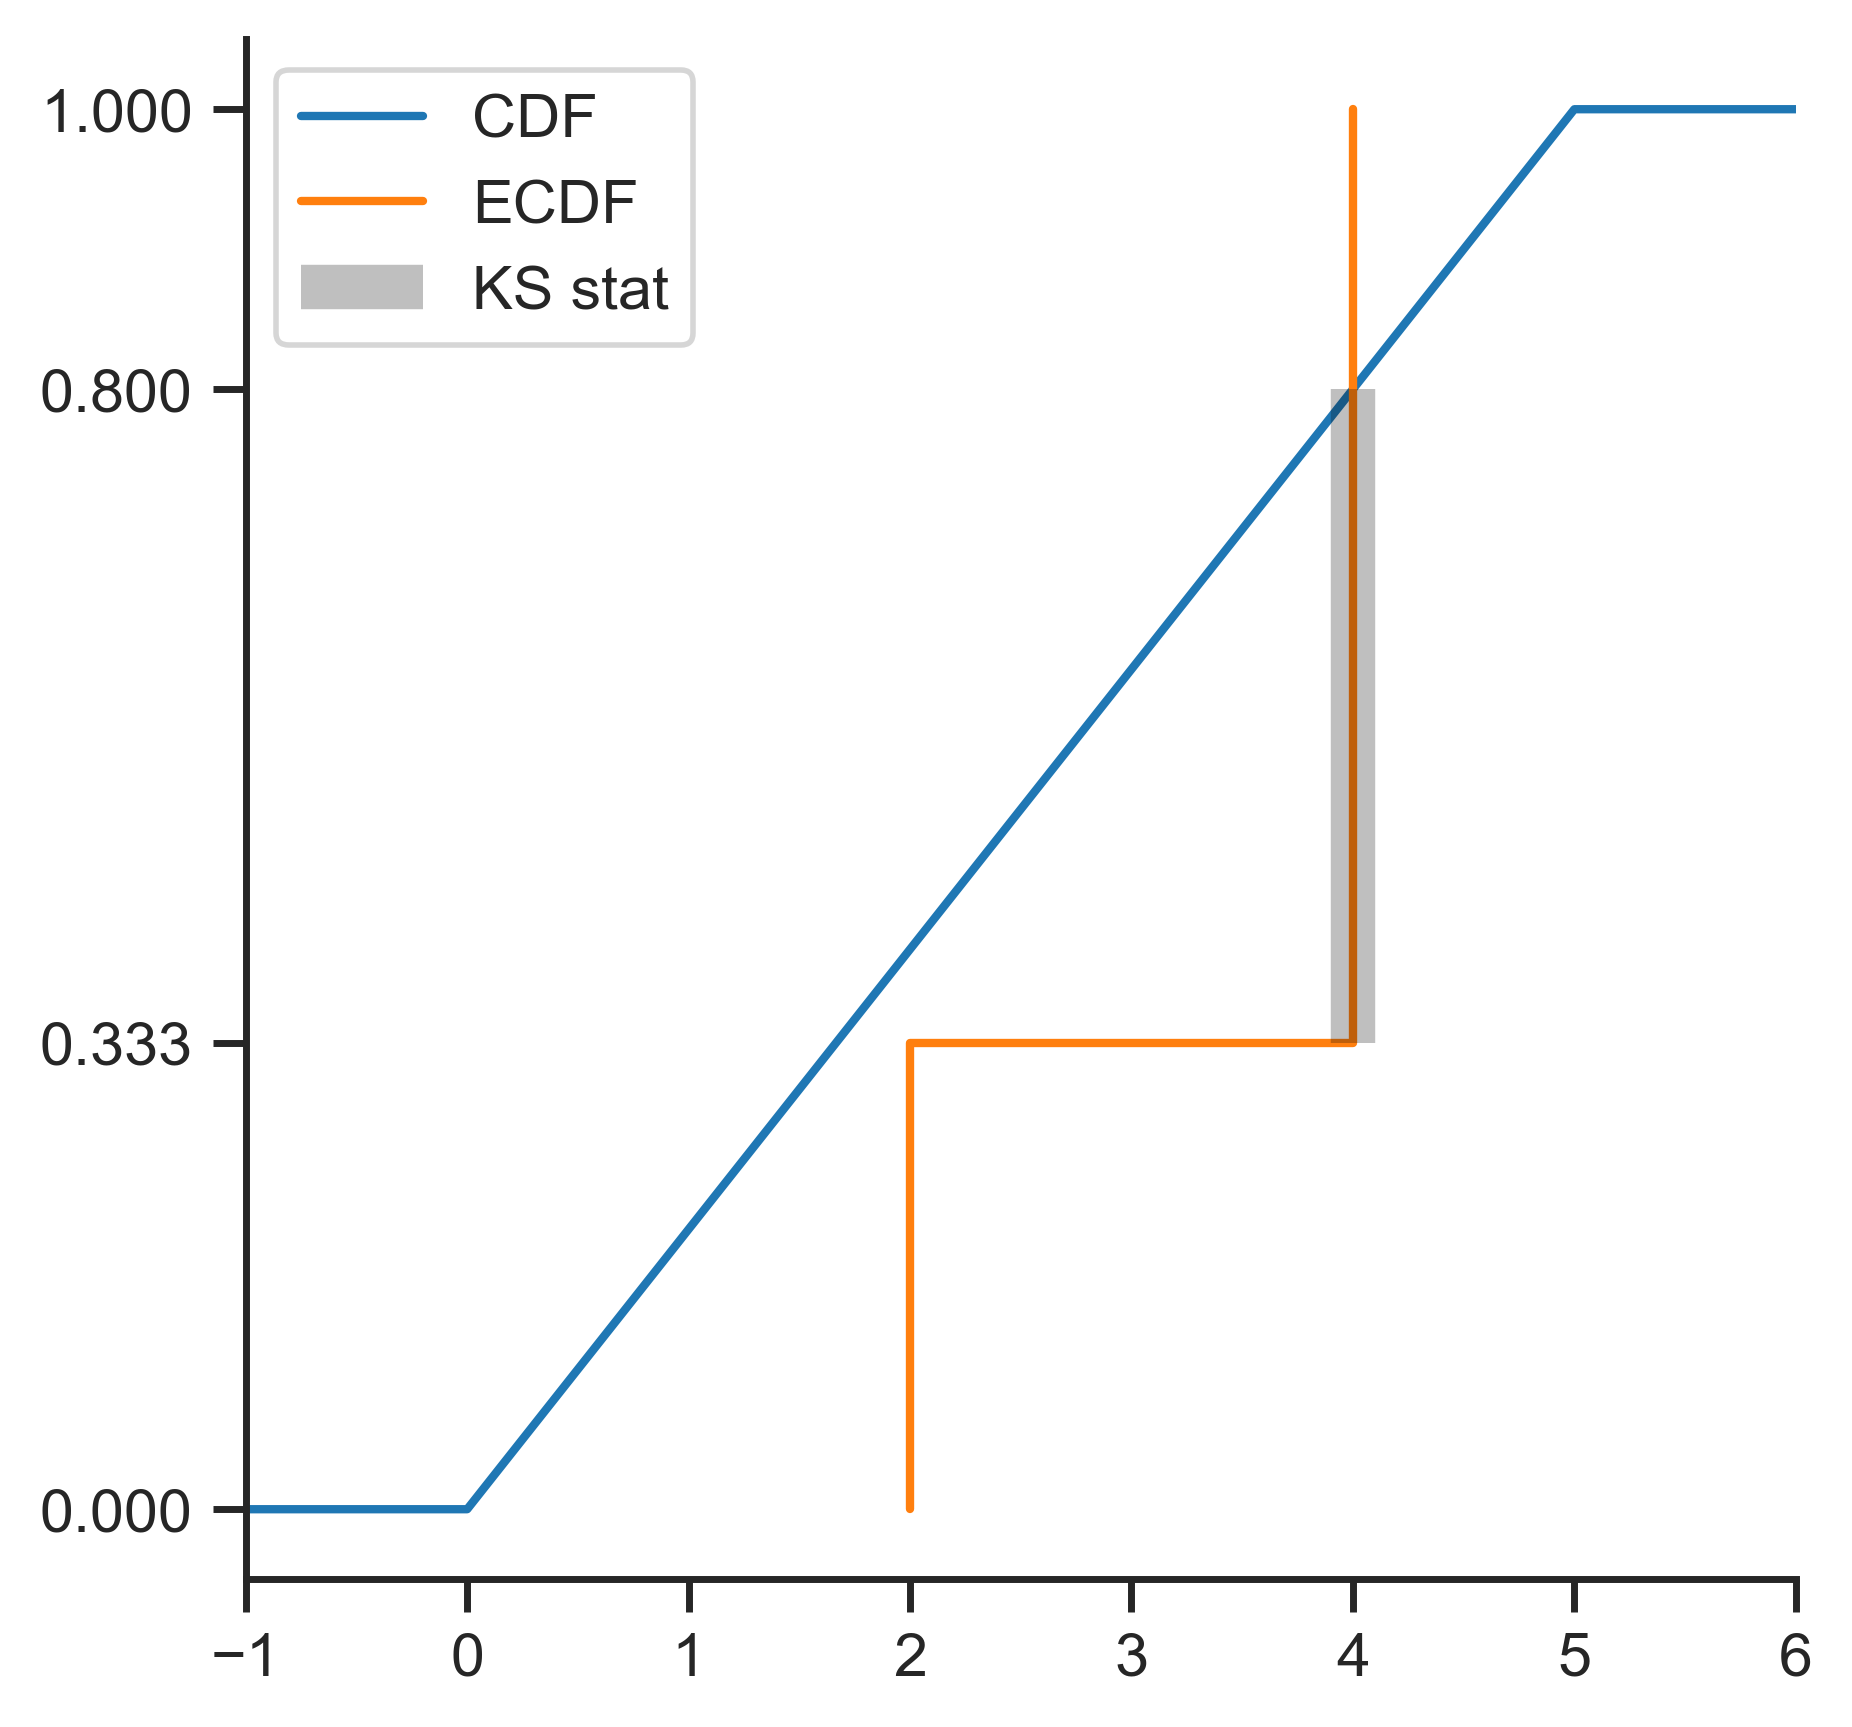

In [54]:
plt.figure(figsize=(5,5))
plt.plot(x, unif.cdf(x), label='CDF')
plt.step(ecdf.x, ecdf.y, where='post', label='ECDF')
plt.vlines(4, *y, color='k', lw=8, alpha=0.25, label='KS stat')
plt.xlim(x[0], x[-1])
plt.xticks(x)
plt.yticks([0, *y, 1])
plt.legend()
plt.show()

In [55]:
res = kstest(sample, unif.cdf)
print_black(res)

KstestResult(
    statistic=0.46666666666666673,
    pvalue=0.4151111111111111,
    statistic_location=4,
    statistic_sign=-1,
)



In [56]:
res.statistic == 4/5 - 1/3

True

In [57]:
'H1' if res.pvalue < alpha else 'H0'

'H0'

***
#### <a id='toc1_5_3_3_'></a>[__Критерий Смирнова__](#toc0_)

Даны две выборки. 

$H_0$: выборки взяты из одного неизвестного распределения. 

$H_1$: выборки происходят из разных распределений.

Тогда статистика критерия Смирнова:

$$\sup_{x \in \mathsf{R}} |F_1(x) - F_2(x)|,$$

где $F_i$ - эмпирическая функция распределения по соответствующей выборке.

[__scipy.stats.kstest__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.kstest.html#scipy-stats-kstest)

***
#### <a id='toc1_5_3_4_'></a>[__Непрерывные в дискретные: группировка наблюдений__](#toc0_)

Если есть непрерывная случайная величина, ее можно преобразовать в дискретную при помощи группировки наблюдений. Поэтому иногда вместо критерия Колмогорова-Смирнова делают группировку наблюдений и применяют критерий хи-квадрат.

Например, непрерывную с.в. время пребывания на сайте можно разбить на нумерованные группы (интервалы) активности пользователей, если раздельный анализ таких групп осмыслен и представляет интерес в рамках бизнес-процессов.

__Общая схема замены непрерывного распределения на дискретное__. Дано непрерывное распределение $F$. Выберем на прямой точки $y_1<y_2<\ldots<y_r$​, разбивающие прямую на $(r+1)$ интервал:
* интервал $(-\infty,y_1]$ с вероятностью попадания в него $F(y_1)$;
* $(y_1,y_2],\;F(y_2)-F(y_1)$;
* $\ldots$
* $(y_{r-1},y_r],\;F(y_r)-F(y_{r-1})$;
* $(y_r,+\infty),\;1-F(y_r).$

***
### <a id='toc1_5_4_'></a>[__Проверка зависимости: хи-квадрат, ANOVA, корреляция__](#toc0_)

***
#### <a id='toc1_5_4_1_'></a>[__Дискретная/дискретная: критерий хи-квадрат__](#toc0_)

Таблица сопряженности:

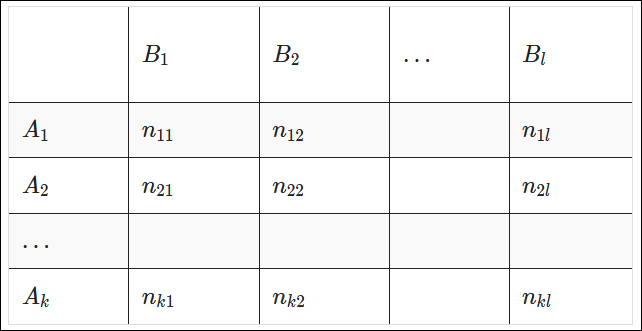

$H_0$: Cлучайные величины $A$ и $B$ независимы.

$H_1$: Случайные величины $A$ и $B$ зависимы.

Статистика:

$$\sum_{i=1}^k \sum_{j=1}^l \frac{(n_{ij} - np_iq_j)^2}{np_iq_j} \sim \chi^2_{(k-1)(l-1)}.$$

In [58]:
def chi2ContHandmade(observed, *, alpha):
    expected = np.multiply(*margins(observed)) / observed.sum()
    statistic = ((observed - expected)**2 / expected).sum()
    # df = (nrows - 1) * (ncols - 1)
    df = np.multiply(*(np.asarray(observed.shape) - 1))
    pvalue = 1 - chi2.cdf(statistic, df=df)
    decision = 'H1' if pvalue < alpha else 'H0'
    fields = ['expected', 'df', 'statistic', 'pvalue', 'decision']
    Result = namedtuple('Result', fields)
    return Result(expected, df, statistic, pvalue, decision)

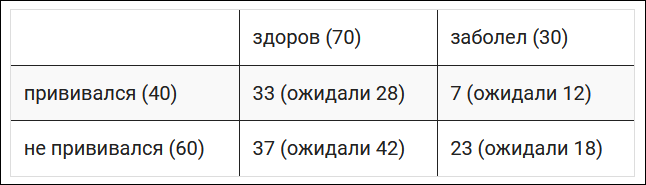

In [59]:
data = np.array([[[33, 7], [37, 23]],
                 [[27, 3], [53, 17]]])

for table in data:
    print_black(chi2_contingency(table, correction=False))
    print_black(chi2ContHandmade(table, alpha=0.05))

Chi2ContingencyResult(
    statistic=4.9603174603174605,
    pvalue=0.025935445587354288,
    dof=1,
    expected_freq=array([[28.0, 12.0], [42.0, 18.0]]),
)

Result(
    expected=array([[28.0, 12.0], [42.0, 18.0]]),
    df=1,
    statistic=4.9603174603174605,
    pvalue=0.025935445587354278,
    decision="H1",
)

Chi2ContingencyResult(
    statistic=2.6785714285714284,
    pvalue=0.10170693003109312,
    dof=1,
    expected_freq=array([[24.0, 6.0], [56.0, 14.0]]),
)

Result(
    expected=array([[24.0, 6.0], [56.0, 14.0]]),
    df=1,
    statistic=2.6785714285714284,
    pvalue=0.1017069300310931,
    decision="H0",
)



In [60]:
table = np.array([[4, 7, 19], [10, 32, 8], [11, 6, 3]])

In [61]:
print_black(chi2ContHandmade(table, alpha=0.05))

Result(
    expected=array([[7.5, 13.5, 9.0], [12.5, 22.5, 15.0], [5.0, 9.0, 6.0]]),
    df=4,
    statistic=33.35185185185185,
    pvalue=1.0118579836237984e-06,
    decision="H1",
)



In [62]:
# аргумент correction не влияет, поскольку dof != 1
print_black(chi2_contingency(table))

Chi2ContingencyResult(
    statistic=33.35185185185185,
    pvalue=1.011857983633579e-06,
    dof=4,
    expected_freq=array([[7.5, 13.5, 9.0], [12.5, 22.5, 15.0], [5.0, 9.0, 6.0]]),
)



***
#### <a id='toc1_5_4_2_'></a>[__Дискретная/непрерывная: дисперсионный анализ (ANOVA)__](#toc0_)

Условия корректности ANOVA ([__scipy.stats.f_oneway__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.f_oneway.html#scipy-stats-f-oneway)):

The ANOVA test has important assumptions that must be satisfied in order for the associated p-value to be valid:
* The samples are independent.
* Each sample is from a normally distributed population.
* The population standard deviations of the groups are all equal. This property is known as homoscedasticity. (_гомоскедастичность_ - см. Кремер, с. 204)

$H_0$: Все элементы из всех групп получены из одного и того же распределения $N(\mu,\sigma^2);\,\mu,\,\sigma$ неизвестны.

$H_1$: Хотя бы две группы происходят из разных распределений.

Будем строить статистику, у которой в числителе __оценка дисперсии между группами__, в знаменателе __оценка внутригрупповой дисперсии__.

$$\Large \frac{c \cdot \frac{1}{r-1}\,\sum_{l=1}^r(\overline{x}_l-\overline{x})^2}{\frac{1}{r(c-1)}\,\sum_{j=1}^r\left(\sum_{i=1}^c(x_{ji}-\overline{x}_j)^2\right)} \sim F_{(\text{dfn, dfd})},$$

где $\text{dfn} := r-1$, n for numerator; $\text{dfd} := r(c-1)$, d for denominator.

Числитель статистики имеет распределение хи-квадрат с $(r-1)$ степенью свободы, умноженное на $\frac{1}{r-1}$ и на $\sigma^2$. Знаменатель статистики имеет распределение хи-квадрат с $r(c-1)$ степенями свободы, умноженное на $\frac{1}{r(c-1)}$ и на $\sigma^2$. $\sigma^2$ сокращается, остается величина, имеющая $F$-распределение с параметрами $(r-1)$ и $r(c-1)$.

Большее значение статистики больше свидетельствует против нулевой гипотезы: различия между группами велики в сравнении с внутригрупповыми различиями.

Критическое множество - правостороннее вида $[a,+\infty)$, где $a$ - квантиль $F_{(r-1),\;r(c-1)}$: см. [__scipy.stats.f__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.f.html#scipy-stats-f).

__Пример__.

In [63]:
def anova1wHandmade(groups, *, alpha):
    """
    One-way ANOVA for groups of same size. 
    """
    r, c = groups.shape
    dfn, dfd = r - 1, r*(c - 1)
    g = lambda group: ((group - group.mean())**2).sum()
    micro = 1/dfd * np.apply_along_axis(g, axis=1, arr=groups).sum()
    macro = c/dfn * ((groups.mean(axis=1) - groups.mean())**2).sum()
    statistic = macro / micro
    pvalue = fdist.sf(statistic, dfn, dfd)
    decision = 'H1' if pvalue < alpha else 'H0'
    fields = ['statistic', 'pvalue', 'decision']
    Result = namedtuple('Result', fields)
    return Result(statistic, pvalue, decision)

In [64]:
data = np.array([[[58, 59, 60, 61, 62],
                  [68, 69, 70, 71, 72],
                  [78, 79, 80, 81, 82]],
                 [[0, 0, 100, 100, 100],
                  [0, 50, 100, 100, 100],
                  [0, 100, 100, 100, 100]]])

for groups in data:
    print(anova1wHandmade(groups, alpha=0.05), f_oneway(*groups), sep='\n')

Result(statistic=200.0, pvalue=6.105260231223841e-10, decision='H1')
F_onewayResult(statistic=200.0, pvalue=6.105260231223841e-10)
Result(statistic=0.2142857142857143, pvalue=0.8101402332206135, decision='H0')
F_onewayResult(statistic=0.21428571428571427, pvalue=0.8101402332206135)


***
#### <a id='toc1_5_4_3_'></a>[__Непрерывная/непрерывная: корреляция__](#toc0_)

__Ковариацией__ (или корреляционным моментом) $\text{cov}_{XY}$ случайных величин $X$ и $Y$ называется математическое ожидание произведения отклонений этих величин от своих математических ожиданий:
$$\mathsf{E}\bigl[(X - \mathsf{E}[X]) \cdot (Y - \mathsf{E}[Y])\bigr]$$

Ковариация двух случайных величин характеризует как степень зависимости случайных величин, так и их рассеяние вокруг точки $(\mathsf{E}[X],\mathsf{E}[Y])$.

__Свойства ковариации__:
* Ковариация двух независимых случайных величин равна нулю.
* Ковариация двух случайных величин равна математическому ожиданию их произведения минус произведение математических ожиданий: 
$$\text{cov}_{XY} = \mathsf{E}(XY) - \mathsf{E}(X) \cdot \mathsf{E}(Y)$$
* Ковариация двух случайных величин по абсолютной величине не превосходит произведения их средних квадратических отклонений:
$$|\text{cov}_{XY}| \leqslant \sigma_X \sigma_Y$$

Ковариация величина размерная, ее размерность определяется произведением размерностей случайных величин. Это затрудняет использование ковариации для оценки степени зависимости для различных случайных величин. Этих недостатков лишен коэффициент корреляции.

__Коэффициентом корреляции__ двух случайных величин называется отношение их ковариации к произведению средних квадратических отклонений этих величин:
$$\text{cor}_{XY} = \frac{\text{cov}_{XY}}{\sigma_X \sigma_Y}$$

__Свойства коэффициента корреляции__:
* $-1 \leqslant \rho \leqslant 1$
* Если случайные величины независимы, то их коэффициент корреляции равен нулю.
* Если коэффициент корреляции двух случайных величин равен (по абсолютной величине) единице, то между этими случайными величинами существует линейная функциональная зависимость.
* Если $\text{cor}_{XY}$ близок к $0$, то либо $X$ и $Y$ независимы, либо зависимость между ними нелинейная.

__Выборочный случай__:

$$\text{cor}_{XY} = \frac{\text{cov}_{XY}}{\sqrt{\mathsf{D}(X) \cdot \mathsf{D}(Y)}} = \frac{\mathsf{E}[(X - \mathsf{E}[X]) \cdot (Y - \mathsf{E}[Y])]}{\sqrt{\mathsf{E}[(X - \mathsf{E}[X])^2] \cdot \mathsf{E}[(Y - \mathsf{E}[Y])^2]}} \approx$$

$$\approx \frac{(1/n) \cdot \sum_{i=1}^n (x_i - \overline{x})(y_i - \overline{y})}{(1/n) \cdot \sqrt{\sum_{i=1}^n (x_i - \overline{x})^2 \cdot \sum_{i=1}^n (y_i - \overline{y})^2}}$$

$$\frac{t_i - \overline{t}}{\sqrt{n}\frac{1}{\sqrt{n}}\sqrt{\sum_{i=1}^n (t_i - \overline{t})^2}} = \frac{t_i - \overline{t}}{\sqrt{n}\sqrt{\frac{1}{n}\sum_{i=1}^n (t_i - \overline{t})^2}} =$$ 

$$= \frac{t_i - \overline{t}}{\sqrt{n}\sqrt{\mathsf{D}_t}} = \frac{1}{\sqrt{n}}\frac{t_i - \overline{t}}{\sigma_t} = \frac{1}{\sqrt{n}} \cdot \text{zscore}(t_i) \Rightarrow$$

$$\text{cor}_{xy} = \frac{1}{n} \sum_{i=1}^n \text{zscore}(x_i) \cdot \text{zscore}(y_i)$$

[__scipy.stats.pearsonr__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.pearsonr.html#scipy-stats-pearsonr) | [__scipy.stats.zscore__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.zscore.html#scipy-stats-zscore) | [__numpy.cov__](https://numpy.org/doc/stable/reference/generated/numpy.cov.html#numpy-cov) | [__Standard: statistics module__](https://docs.python.org/3.10/library/statistics.html?highlight=covariance#module-statistics)

__Пример__.

In [65]:
points = (1, 3), (-4, -1), (6, 4), (-8, -3), (10, 7)
x, y = zip(*points)

In [66]:
zscore(x) @ zscore(y) / len(points)

0.9872790533812024

In [67]:
correlation(x, y)

0.9872790533812024

In [68]:
pearsonr(x, y)

PearsonRResult(statistic=0.9872790533812025, pvalue=0.001719026493819863)

In [69]:
np.cov(x, y, bias=True)[0][-1]  # или ddof=0

23.0

***